<a href="https://colab.research.google.com/github/MaximKray21/CV_Projects/blob/main/emotion%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision import transforms as tfs
from sklearn.preprocessing import LabelEncoder
import pickle
from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import pathlib
import matplotlib.pyplot as plt
import torchvision
from torchvision import models
import torch
from torchvision.models import resnet152
from torch import nn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive/


In [ ]:
images_path = '/content/drive/MyDrive/Colab Notebooks/emotion classification/images'

In [ ]:
path = pathlib.Path(images_path + '/6')
labels = dict(zip( [file_.name.replace('.jpg', '') for file_ in path.iterdir()], range(8) ))
labels

{'Fear': 0,
 'Disgust': 1,
 'Contempt': 2,
 'Anger': 3,
 'Surprised': 4,
 'Sad': 5,
 'Neutral': 6,
 'Happy': 7}

In [ ]:
img_by_clss = '/content/drive/MyDrive/Colab Notebooks/emotion classification/images_by_classes/train'

In [ ]:
path = pathlib.Path(images_path)
persons = [person.name for person in path.iterdir()]

for person in persons:
  p = images_path + '/' + person
  p = pathlib.Path(p)
  imgs = [img for img in p.iterdir()]
  imgs_names = [img.name.replace('.jpg', '') for img in p.iterdir()]

  for i, img in enumerate(imgs):
    img = Image.open(img)
    img.save(img_by_clss + '/' + imgs_names[i] + '/' + person + '.jpg', 'JPEG')


['Disgust',
 'Contempt',
 'Anger',
 'Happy',
 'Fear',
 'Surprised',
 'Sad',
 'Neutral']

In [ ]:
modes = ['train', 'test']

class EmotionsDataset(Dataset):
  def __init__(self, files, mode):
    self.files = files
    self.mode = mode
    self.len_ = len(self.files)
    self.label_encoder = LabelEncoder()

    if self.mode == 'train':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open('le.pickle', 'wb') as dumped_file:
        pickle.dump(self.label_encoder, dumped_file)

  def __len__(self):
    return self.len_

  def load_img(self, file):
    img = Image.open(file)
    img.load()
    return img

  def __getitem__(self, indx):
    if self.mode == 'test':
      transform = tfs.Compose([
          tfs.Resize(size = (224, 224), antialias = True),
          tfs.Lambda(lambda x: np.array(x, dtype = 'float32') / 255),
          tfs.ToTensor(),
          tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])
    else:
      augmentation = tfs.RandomChoice([
          tfs.Compose([
              tfs.Resize(size = 300, max_size = 301),
              tfs.CenterCrop(300),
              tfs.RandomCrop(250)
          ]),
          tfs.RandomRotation((-25, 25)),
          tfs.RandomHorizontalFlip(p=1)
          ])
      transform = tfs.Compose([
          augmentation,
          tfs.Resize(size = (224, 224), antialias=True),
          tfs.Lambda(lambda x: np.array(x, dtype = 'float32') / 255),
          tfs.ToTensor(),
          tfs.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])

    file = self.files[indx]
    x = self.load_img(file)
    x = transform(x)

    if self.mode == 'test':
      return x
    else:
      label = self.labels[indx]
      label_id = self.label_encoder.transform([label])
      y = label_id.item()
      return x, y

In [ ]:
train_files = sorted(list(pathlib.Path(img_by_clss).glob('**/*.jpg')))

In [ ]:
len(train_files)

152

In [ ]:
train_dataset = EmotionsDataset(train_files, mode = 'train')

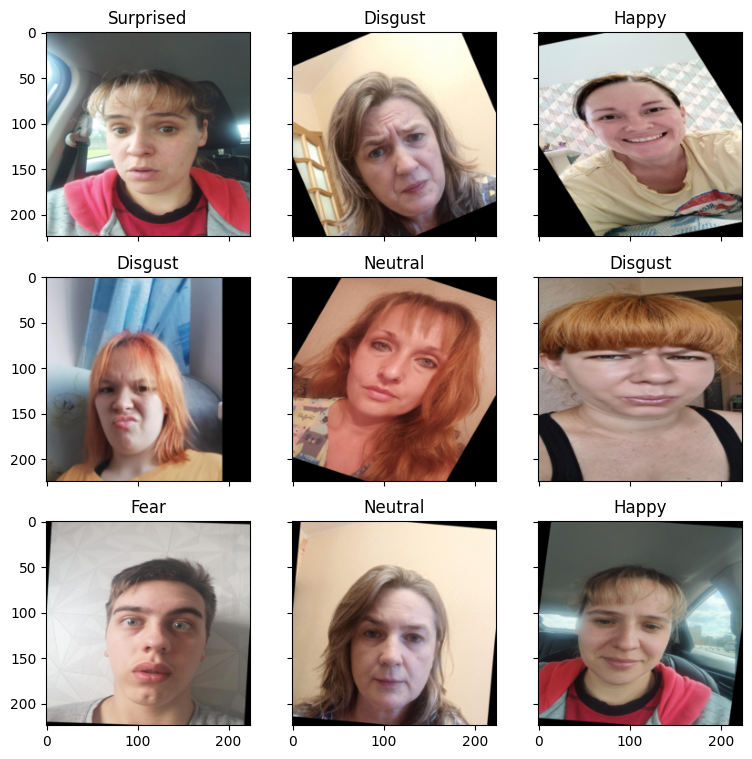

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

fig, ax = plt.subplots(figsize = (9, 9), sharey = True, sharex = True,
                       nrows = 3, ncols = 3)

for figx in ax.ravel():
  random_chr = np.array(np.random.uniform(len(train_files)), dtype = 'int').item()
  img, label = train_dataset[random_chr]
  img = img.permute(1,2,0)
  img = img * std + mean
  img = np.clip(img, 0, 1)
  figx.set_title(' '.join(train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
  figx.imshow(img)

In [ ]:
# train, test = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.85), len(train_dataset) - int(len(train_dataset) * 0.85)])

In [ ]:
model = resnet152(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for param in model.parameters():
  param.requires_grad = False

In [ ]:
fc = nn.Sequential(nn.Linear(in_features=model.fc.in_features, out_features=model.fc.out_features),
              nn.Linear(in_features=model.fc.out_features, out_features=len(labels)),
              )
model.fc = fc

In [ ]:
# for param in model.parameters():
#   print(param.requires_grad)

In [ ]:
best_model_params_path = '/content/drive/MyDrive/Colab Notebooks/emotion classification/images_by_classes'

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

SyntaxError: incomplete input (<ipython-input-78-c3d3b674ef20>, line 1)